# А/В-тест

**План**
1. [Приоритизировать гипотезы:](#prior)
   - ICE,
   - RICE.
2. [Анализ результатов А/В-теста:](#ab)
   - [кумулятивная выручка,](#rev)
   - [кумулятивный средний чек,](#aov)
   - [кумулятивная конверсия,](#cr)
   - [выявить и удалить выбросы,](#outliers)
   - [проверить статистическую значимость изменений.](#test)

## Импортируем библиотеки

In [1]:
# импортируем библиотеки, необходимые для работы
import pandas as pd # для работы с данными
import numpy as np # для работы с числами
import seaborn as sns # для визуализации
import matplotlib.pyplot as plt # для настройки визуализации
import scipy.stats as st # для проверки гипотез
import datetime as dt # для работы с датами
%matplotlib inline
%config InlineBackend.figure_format='retina' # повышение четкости графиков
plt.style.use('seaborn-darkgrid') # задаём стиль графиков
pd.set_option('max_colwidth', 800) # расширяем максимальную ширину столбцов

<a id='prior'></a>

## Приоритизируем гипотезы

Прочитаем файл с гипотезами.

In [2]:
hyps = pd.read_csv('hypothesis.csv')

Запишем столбцы в переменные, чтобы было удобнее считать показатели.

In [3]:
reach = hyps['Reach']
impact = hyps['Impact']
confidence = hyps['Confidence']
efforts = hyps['Efforts']

Посчитаем значения фреймворков **ICE** и **RICE** и запишем в соотвесттвующие столбцы.

In [4]:
hyps['ice'] = impact * confidence / efforts
hyps['rice'] = reach * impact * confidence / efforts

Отсортируем данные по убыванию приоритета по фрейморку **ICE.**

In [5]:
hyps.sort_values('ice', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Наибольший приоритет у гипотезы, предлагающей давать скидку в день рождения. Проверим сортировку по **RICE.**

In [6]:
hyps.sort_values('rice', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Акция со скидками на день рождения опустилась на 5 место — всё из-за низкого показателя *Reach.* По этой же причине одну позицию потеряла гипотеза о добавлении новых каналов трафика. На первое место вырвалась форма подписки на страницы в соцсетях. Это произошло за счёт высокого *Reach* и сравнительного невысокого *Efforts*. В целом видно, что в обоих случаях наверху списка оказываются гипотезы с низкими затратами, а во втором случае — с высоким «покрытием».

<a id='ab'></a>

## Анализ результатов А/В-теста.

Прочитаем файл с заказами.

In [7]:
orders = pd.read_csv('orders.csv')

Напишем функцию, которая будет принимать датафрейм, стандартизировать названия его столбцов, переводить дату в формат `datetime`, а также возвращать основные сведения о данных.

In [8]:
def preanalyze(data):
    '''
    Приводит названия столбцов к виду "column_name", приводит дату к типу datetime, возвращает
    результаты методов info и describe, выводит первые 5 строк и количество дубликатов в данных.
    
    Параметры:
    data (DataFrame) — датасет, который нужно обработать.
    '''
    data.columns = data.columns.str.lower().str.replace('id', '_id')
    data['date'] = data['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
    display(data.info())
    display(data.describe())
    display(data.head())
    print('Дубликаты:', data.duplicated().sum())

С помощью функции посмотрим на данные о заказах.

In [9]:
preanalyze(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

,transaction_id,visitor_id,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Дубликаты: 0


Пропусков и дубликатов нет, но явно есть выбросы: 3-й квартиль выручки находится на уровне 8 тысяч, а максимум — больше миллиона.

Проверим, нет ли в данных «фликеров» — пользователей, которые попали в обе группы.

In [10]:
orders.query('group=="A"')['visitor_id'].nunique() + orders.query('group=="B"')['visitor_id'].nunique()\
- orders['visitor_id'].nunique()

58

Таких пользователей оказалось целых 58. Их лучше удалить, чтобы не портить результаты теста. Создадим список пользователей в обеих группах и избавимся от всех дубликатов. Параметр `keep=False` удалит все значения, которые встречаются более одного раза.

In [11]:
visitors_clean = (
    orders
    .groupby(['visitor_id', 'group'], as_index=False)
    ['transaction_id']
    .count()
    .drop_duplicates(subset='visitor_id', keep=False)
    ['visitor_id']
)

Посмотрим, сколько пользователей мы удалили. «Лишних» было 58.

In [12]:
orders['visitor_id'].nunique() - len(visitors_clean)

58

Отлично, теперь с данными всё в порядке, можно двигаться дальше. В таблице с заказами оставим только пользователей из очищенного списка.

In [13]:
orders = orders.query('visitor_id in @visitors_clean')

<a id='rev'></a>

### Кумулятивная выручка

Создадим таблицу с датами и группами, чтобы затем при помощи неё посчитать кумулятивную выручку.

In [14]:
dates_groups = orders[['date', 'group']].drop_duplicates()

При помощи `lambda`-функции посчитаем кумулятивную выручку по группам.

In [15]:
cum_revenue = (
    dates_groups
    .apply(
        lambda x:
        orders[
            (orders['date']<=x['date'])&(orders['group']==x['group'])
        ]
        .agg({
            'date': 'max',
            'group': 'max',
            'visitor_id': 'nunique',
            'transaction_id': 'nunique',
            'revenue': 'sum'}),
        axis=1)
    .sort_values(['date', 'group'])
)

In [16]:
cum_revenue.head(3)

,date,group,visitor_id,transaction_id,revenue
55,2019-08-01,A,19,23,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,36,42,234381


Графики нам придётся строить много раз. Чтобы делать это проще, напишем функцию.

In [17]:
def line(data, y, title, ylabel, hue='group'):
    '''
    Строит линейный график по заданным параметрам.
    
    Параметры:
    data (DataFrame) — датафрейм, по которому строится график.
    y (Series) — показатель, изменение которого во времени нужно отследить.
    title (str) — заголовок графика.
    ylabel (str) — подпись оси y.
    hue (Series) — параметр, по которому данные будут разделены. По умолчанию деление происходит по группам.
    '''
    plt.figure(figsize=(8,4)) # размер фигуры
    sns.lineplot(
        x='date', # x — всегда дата, т.к. мы отслеживаем изменение во времени
        y=y,
        hue=hue,
        data=data,
        palette='crest', # цветовая схема
        color='teal' # цвет графика, если линия будет одна
    )
    plt.title( # параметры заголовка
        title,
        fontsize=20,
        fontweight='bold',
        color='teal'
    )
    plt.xlabel( # параметры подписи оси X
        'Дата',
        fontsize=14
    )
    plt.ylabel( # параметры подписи оси Y.
        ylabel,
        fontsize=14
    )
    plt.xticks(rotation=45); # поворачиваем подписи дат на 45 градусов, чтобы они не накладывались друг на друга

При помощи функции строим график изменения кумулятивной выручки по группам.

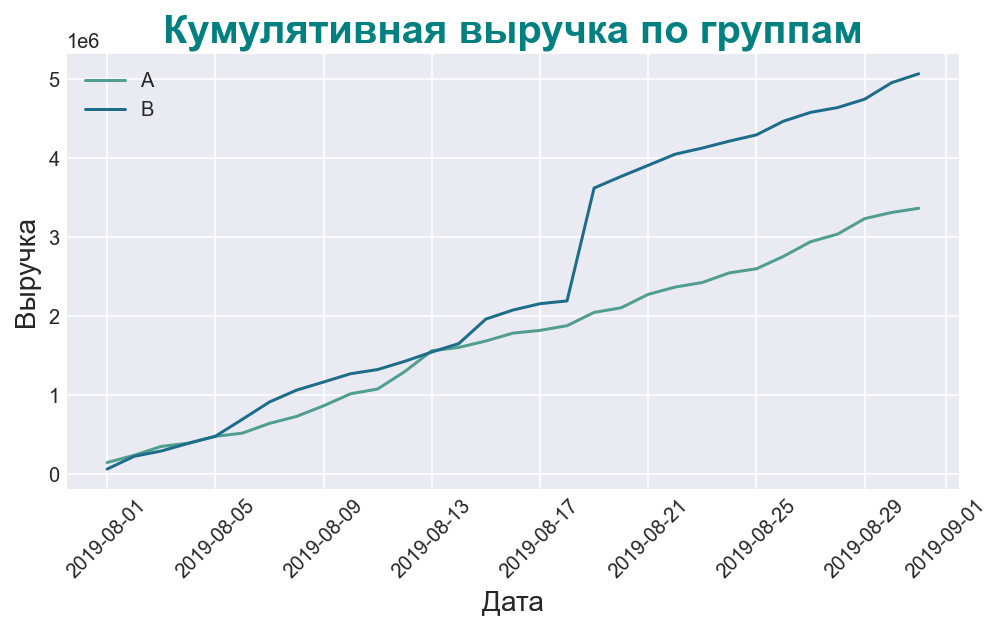

In [18]:
line(cum_revenue, 'revenue', 'Кумулятивная выручка по группам', 'Выручка')
plt.legend();

Выручка обеих групп была почти одинаковой, но в какой-то момент произошла очень дорогая покупка, и группа В вырвалась вперёд. Затем графики снова стали расти параллельно, значит, существенных различий между группами, скорее всего, нет.

<a id='aov'></a>

### Кумулятивный средний чек

Прочитаем таблицу с данными о посещениях сайта.

In [19]:
visitors = pd.read_csv('visitors.csv')

Используя ранее написанную функцию обработаем данные и посмотрим на основную информацию о них.

In [20]:
preanalyze(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Дубликаты: 0


Дубликатов и пропусков нет, выбросов тоже. С данными можно работать. Также проверим, что группы имеют одинаковый размер.

In [21]:
visitors.query('group=="A"')['visitors'].sum()/visitors.query('group=="B"')['visitors'].sum()

0.9904842461408332

Группа В менее чем на 1% больше группы А. Тест можно продолжать.

При помощи `lambda`-функции посчитаем кумулятивное количество визитов сайта по группам.

In [22]:
cum_visitors = (
    dates_groups
    .apply(
        lambda x:
        visitors[
            (visitors['date']<=x['date'])&(visitors['group']==x['group'])
        ]
        .agg({
            'date': 'max',
            'group': 'max',
            'visitors': 'sum'}),
        axis=1)
    .sort_values(['date', 'group'])
)

Объединим данные о выручке и визитах в одну таблицу при помощи метода `merge`.

In [23]:
cum_data = cum_revenue.merge(cum_visitors, on=['date', 'group'])

In [24]:
cum_data.tail(3)

,date,group,visitor_id,transaction_id,revenue,visitors
59,2019-08-30,B,511,531,4955833,18198
60,2019-08-31,A,445,468,3364656,18736
61,2019-08-31,B,528,548,5068972,18916


Посчитаем кумулятивный средний чек: разделим выручку на количество заказов.

In [25]:
cum_data['aov'] = cum_data['revenue'] / cum_data['transaction_id']

При помощи функции `line` построим график кумулятивного среднего чека по группам.

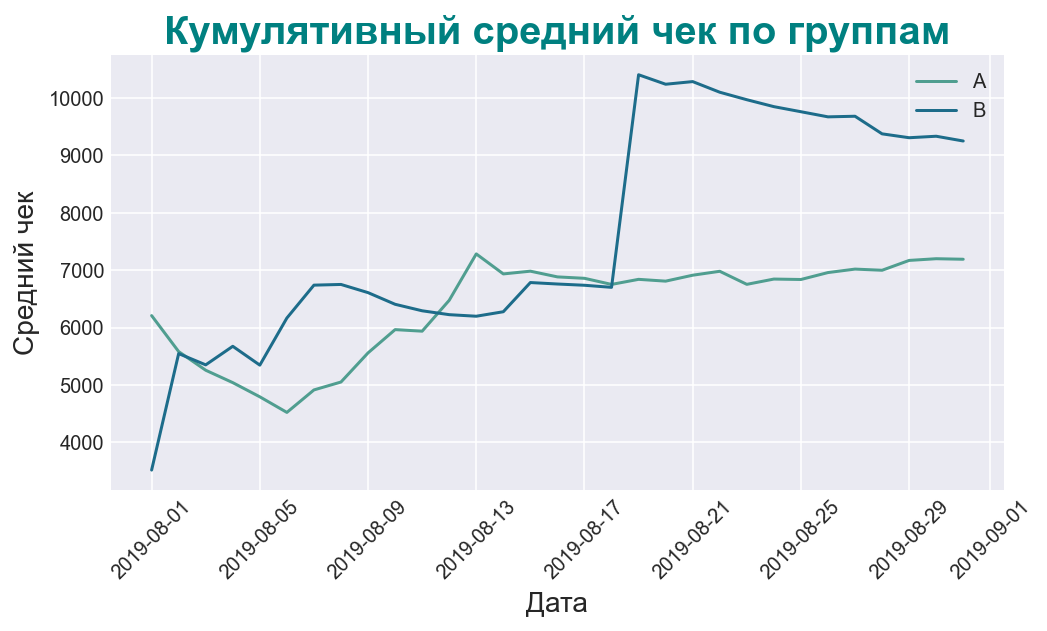

In [26]:
line(cum_data, 'aov', 'Кумулятивный средний чек по группам', 'Средний чек')
plt.legend();

15 августа данные начали стабилизироваться: графики стали выравниваться. Но затем в группе В произошёл тот самый выброс, который очень сильно исказил данные. Затем средний чек группы В начал снижаться, возвращаясь к нормальным значениям, но пока до них так и не дошёл.

<a id='cr'></a>

### Кумулятивная конверсия

Теперь посчитаем кумулятивную конверсию в покупку: разделим число заказов на число посещений сайта.

In [27]:
cum_data['cr'] = cum_data['transaction_id'] / cum_data['visitors']

Чтобы посчитать относительное изменение метрик, разделим таблицу на два среза по группам, а затем объединим их по дате методом `merge`.

In [28]:
cum_data_a = cum_data.query('group=="A"')[['date', 'group', 'aov', 'cr']]
cum_data_b = cum_data.query('group=="B"')[['date', 'group', 'aov', 'cr']]

rel_data = cum_data_a.merge(cum_data_b, on='date', suffixes=['_a', '_b'])

Посчитаем относительное изменение среднего чека и конверсии.

In [29]:
rel_data['rel_aov'] = rel_data['aov_b'] / rel_data['aov_a'] - 1
rel_data['rel_cr'] = rel_data['cr_b'] / rel_data['cr_a'] - 1

Построим график относительного изменения среднего чека при помощи нашей функции.

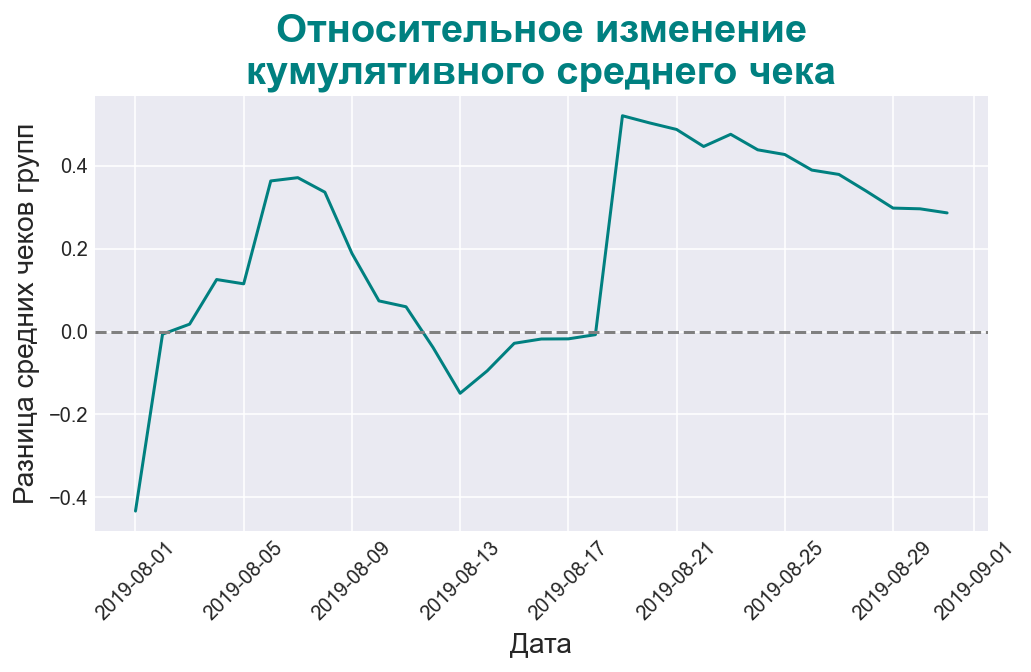

In [30]:
line(
    rel_data,
    'rel_aov',
    'Относительное изменение\nкумулятивного среднего чека',
    'Разница средних чеков групп',
    hue=None)
plt.axhline(y=0, linestyle='--', color='gray');

Выброс не позволяет делать однозначный вывод. От него нужно избавиться.

Теперь построим график кумулятивной конверсии в покупку.

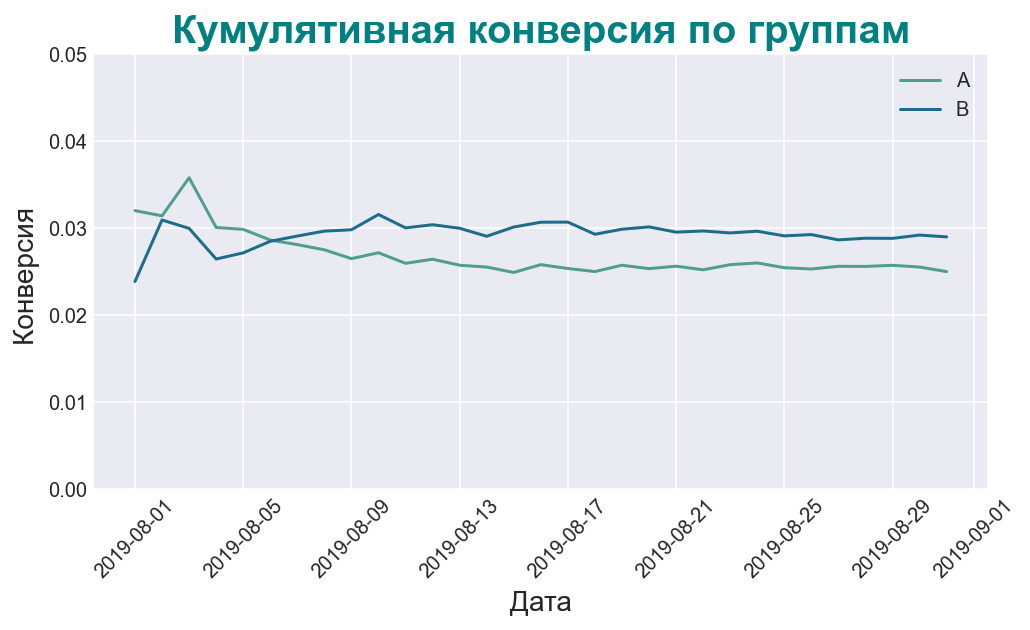

In [31]:
line(cum_data, 'cr', 'Кумулятивная конверсия по группам', 'Конверсия ')
plt.legend()
plt.ylim(0, 0.05);

График довольно быстро стабилизировался и можно говорить о том, что конверсия группы В выше, чем у группы А. Проверим это на графике относительного изменения.

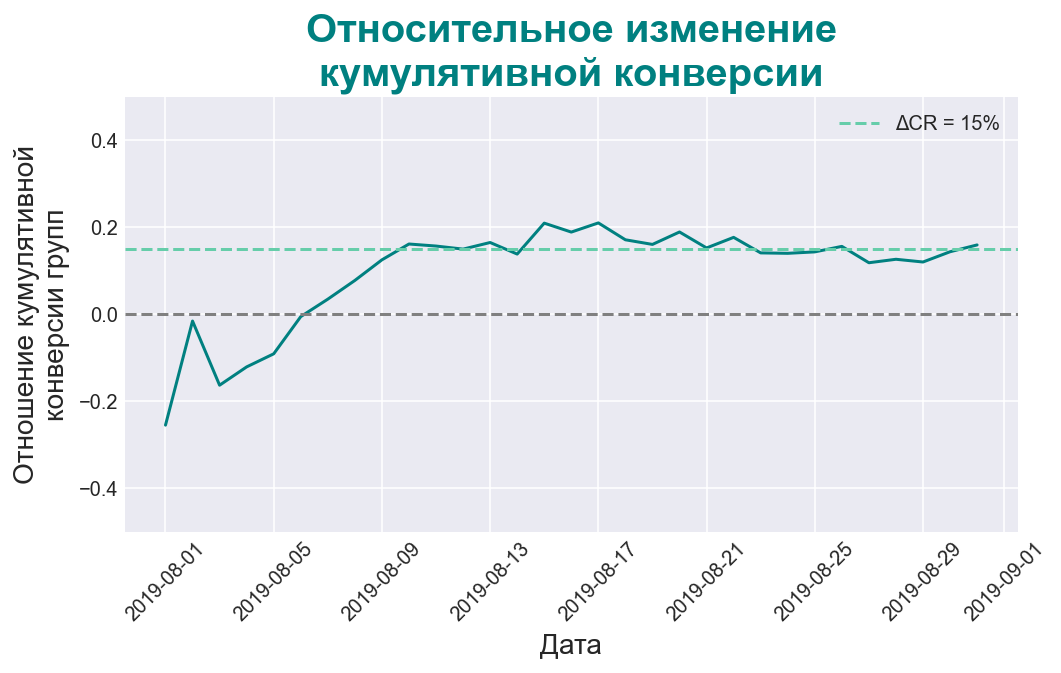

In [32]:
line(
    rel_data,
    'rel_cr',
    'Относительное изменение\nкумулятивной конверсии',
    'Отношение кумулятивной\nконверсии групп',
    hue=None)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=0.15, linestyle='--', color='mediumaquamarine', label='\u0394CR = 15%')
plt.ylim(-0.5, 0.5)
plt.legend();

Конверсия группы В примерно **на 15% выше,** чем у группы А. Причем график долго и довольно стабильно находится на этом уровне. Осталось проверить, является ли прирост статистически значимым. Но перед этим посмотрим на выбросы.

### Поиск выбросов

Создадим таблицу с данными о количестве заказов каждого пользователя.

In [33]:
customers_orders = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})

Построим точечный график, чтобы увидеть распределение количества заказов каждого пользователя сайта.

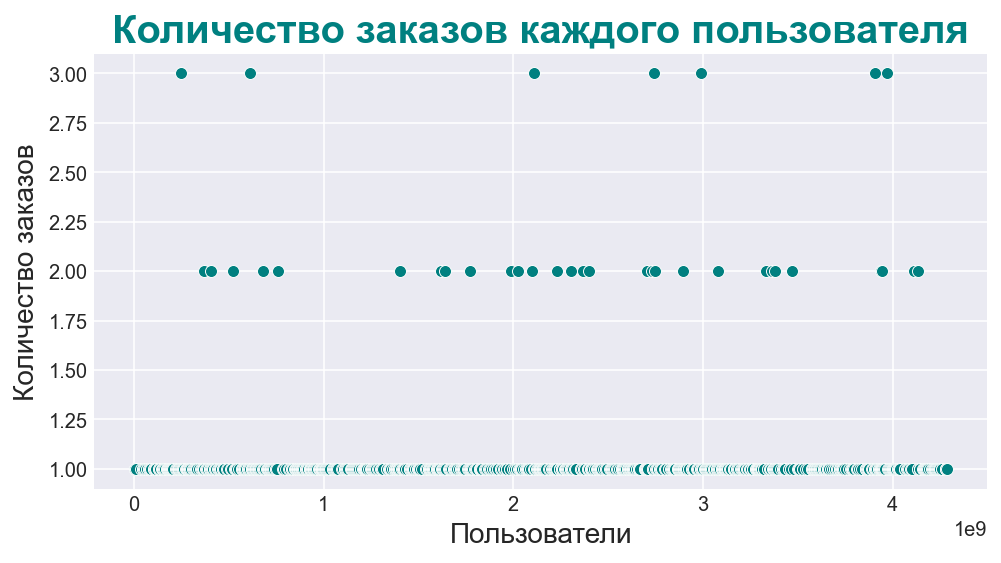

In [34]:
plt.figure(figsize=(8,4))
sns.scatterplot(
    data=customers_orders,
    x='visitor_id',
    y='transaction_id',
    color='teal'
)
plt.title(
    'Количество заказов каждого пользователя',
    fontsize=20,
    fontweight='bold',
    color='teal'
)
plt.xlabel(
    'Пользователи',
    fontsize=14
)
plt.ylabel(
    'Количество заказов',
    fontsize=14
);

Самое большое число заказов — 3. При этом пользователей, сделавших 3 заказа, немного, они не исказят распределение. Посчитаем 90, 95 и 99-й перцентили количества заказов.

In [35]:
np.percentile(customers_orders['transaction_id'], [90, 95, 99])

array([1., 1., 2.])

**95% пользователей сделали только один заказ.** Только 1% — больше 2 заказов. Тем не менее даже тех, кто сделал 3 заказа, *нельзя считать «аномальными».* Таких пользователей немного и *они не искажают распределение.* С точки зрения количества заказов все пользователи ведут себя нормально, и мы оставим их в данных. Посмотрим также на график распределения стоимости заказов.

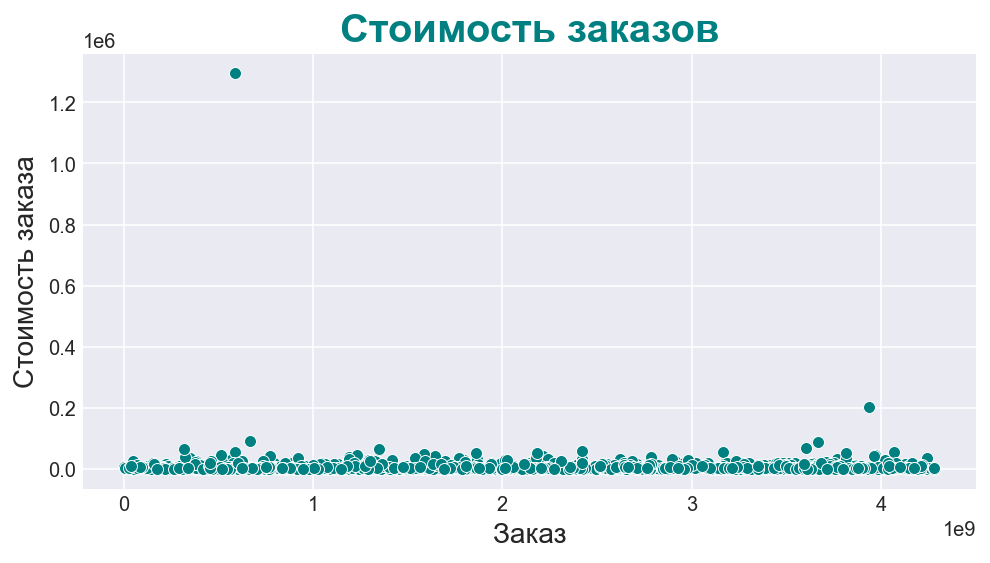

In [36]:
plt.figure(figsize=(8,4))
sns.scatterplot(
    data=orders,
    x='transaction_id',
    y='revenue',
    color='teal'
)
plt.title(
    'Стоимость заказов',
    fontsize=20,
    fontweight='bold',
    color='teal'
)
plt.xlabel(
    'Заказ',
    fontsize=14
)
plt.ylabel(
    'Стоимость заказа',
    fontsize=14
);

Вот и тот самый выброс, который мы обнаружили в самом начале. Кто-то совершил заказ на безумные **1,3 миллиона.** Также есть другие дорогие заказы. Посчитаем перцентили, чтобы понимать, какие заказы считать слишком дорогими.

In [37]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

Только 5% заказов — дороже 27 тысяч, 1% — дороже 54 тысяч. Будем считать заказы **дороже 50 тысяч** выбросами, таким образом избавившись от 1-5% аномальных заказов.

<a id='test'></a>

### Проверяем гипотезы

Переименуем столбцы в таблице с кумулятивными данными и в таблице с визитами для удобства.

In [38]:
cum_data = cum_data.rename(columns={
    'visitor_id': 'cum_buyers',
    'transaction_id': 'cum_orders',
    'revenue': 'cum_revenue',
    'visitors': 'cum_users'
})
visitors = visitors.rename(columns={'visitors': 'visitors_daily'})

Напишем функцию, которая будет принимать датасет и группу, а возвращать выборку, сделанную по этой группе.

In [39]:
def sample(df, group):
    '''
    Возвращает выборку количества заказов каждого пользователя группы из датасета.
    
    Параметры:
    df (DataFrame) — датафрейм, из которого будет формироваться выборка.
    group (Series) — группа, по которой будет формироваться выборка.
    '''
    data = ( # считаем количество заказов для платящих пользователей
        df
        .query('group==@group')
        .groupby('visitor_id', as_index=False)
        .agg({'transaction_id': 'nunique'})
    )
    data.columns = ['visitor_id', 'orders']
    sample = pd.concat( # объединяем с пользователями, не совершавшими заказ
        [data['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors.query('group==@group')['visitors_daily'].sum()-len(data['orders'])
            ),
            name='orders'
        )
        ]
    )
    return sample

При помощи функции сформируем две выборки из таблицы с заказами — по группе А и группе В.

In [40]:
sample_a = sample(orders, 'A')
sample_b = sample(orders, 'B')

При помощи теста Манна-Уитни посчитаем статистическую значимость различий между конверсиями групп.

In [41]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(sample_a, sample_b)[1]))
print('\u0394CR: {0:.1%}'.format(sample_b.mean() / sample_a.mean() - 1))

p-value: 0.011
ΔCR: 16.0%


**Конверсии отличаются статистически значимо:** p-уровень значимости равенства выборочных средних чуть больше одной сотой, т.е. существенно меньше уровня значимости 0.05. Конверсия группы В выше на 16%, что подтверждает выводы из графиков.

Также посмотрим на различия среднего чека групп.

In [42]:
print(
    'p-value: {0:.3f}'
    .format(
        st.mannwhitneyu(
            orders.query('group=="A"')['revenue'],
            orders.query('group=="B"')['revenue'])
        [1]))
print(
    '\u0394AOV: {0:.1%}'
    .format(
        orders.query('group=="B"')['revenue'].mean()/orders.query('group=="A"')['revenue'].mean()-1)) 

p-value: 0.829
ΔAOV: 28.7%


Средний чек группы В выше почти на 29%, но это получилось за счёт выбросов. Тем временем U-тест Манна-Уитни не показывает статистически значимых различий между выборками. Значит, средний чек, с большой вероятностью, изменился только под действием выбросов, а реального увеличения под действием изменений на сайте не произошло.

<a id='outliers'></a>

Очистим выборки от выбросов. Функции `sample` передадим данные заказов дешевле 50 тысяч.

In [43]:
sample_a_clean = sample(orders.query('revenue<50000'), 'A')
sample_b_clean = sample(orders.query('revenue<50000'), 'B')

Снова посмотрим на изменение конверсии.

In [44]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(sample_a_clean, sample_b_clean)[1]))
print('\u0394CR: {0:.1%}'.format(sample_b_clean.mean() / sample_a_clean.mean() - 1))

p-value: 0.009
ΔCR: 17.0%


Изменения небольшие, но в лучшую сторону. Разница конверсий увеличилась, значимость различий выборок также возросла. Можно утверждать, что с высокой вероятностью в результате изменений на сайте произошло **увеличение конверсии в покупку на 17%.** Однако об успешности теста говорить рано: ведь мог уменьшиться средний чек, и тогда выручка магазина могла снизиться. Проверим изменение среднего чека на очищенных данных.

In [45]:
print(
    'p-value: {0:.3f}'
    .format(
        st.mannwhitneyu(
            orders.query('group=="A" and revenue<50000')['revenue'],
            orders.query('group=="B" and revenue<50000')['revenue'])
        [1]))
print(
    '\u0394AOV: {0:.1%}'
    .format(
        orders.query('group=="B" and revenue<50000')['revenue'].mean()\
        /orders.query('group=="A" and revenue<50000')['revenue'].mean()-1))

p-value: 0.991
ΔAOV: 0.5%


p-уровень значимости — почти единица. Это значит, что даже те 0.5% прироста среднего чека, которые мы получили, почти наверняка получились случайно. Удаление выбросов свело на нет лидерство группы В. Посмотрим на графики кумулятивной выручки, кумулятивного чека и относительного изменения среднего чека по очищенным данным, чтобы сделать окончательные выводы.

In [46]:
cum_revenue_clean = (
    dates_groups
    .apply(
        lambda x:
        orders[
            (orders['date']<=x['date'])&(orders['group']==x['group'])&(orders['revenue']<50000)
        ]
        .agg({
            'date': 'max',
            'group': 'max',
            'visitor_id': 'nunique',
            'transaction_id': 'nunique',
            'revenue': 'sum'}),
        axis=1)
    .sort_values(['date', 'group'])
)
cum_data_clean = cum_revenue_clean.merge(cum_visitors, on=['date', 'group'])
cum_data_clean['aov'] = cum_data_clean['revenue'] / cum_data_clean['transaction_id']

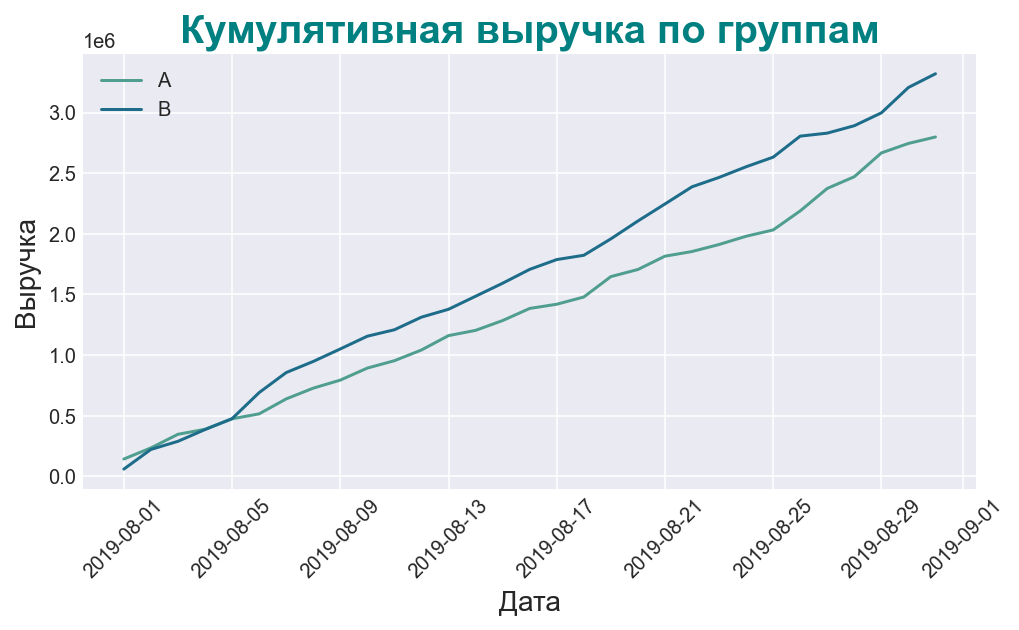

In [47]:
line(cum_revenue_clean, 'revenue', 'Кумулятивная выручка по группам', 'Выручка')
plt.legend();

Выручка группы В всё ещё выше, чем у группы А, но это может объясняться только увеличением конверсии в покупку. Посмотрим на кумулятивный средний чек.

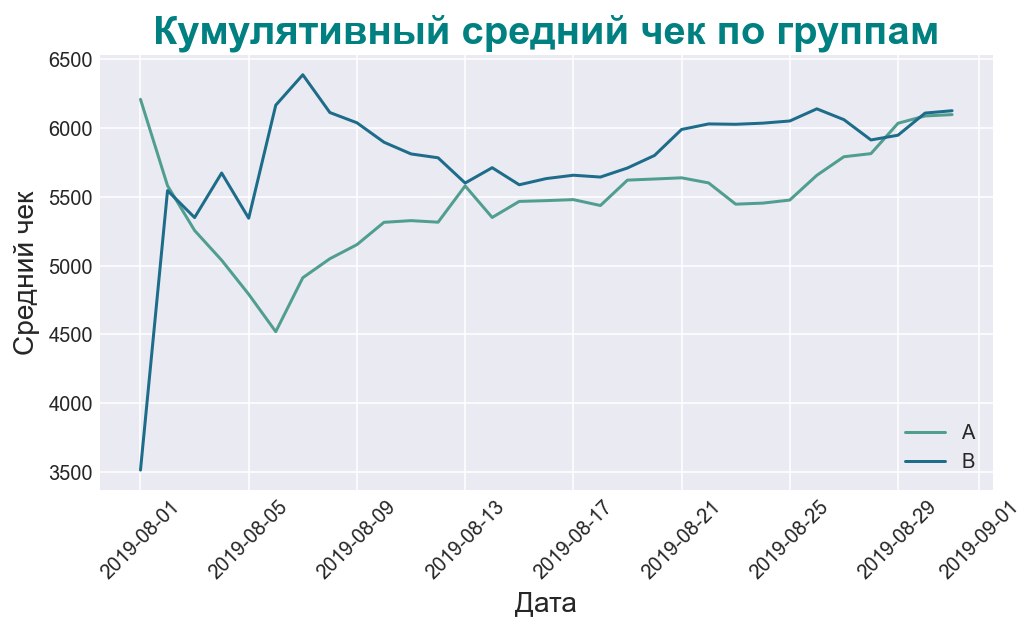

In [48]:
line(cum_data_clean, 'aov', 'Кумулятивный средний чек по группам', 'Средний чек')
plt.legend();

График так и не стабилизировался. Группа В то опережает группу А, то равняется с ней по среднему чеку. В последние дни теста обе группы идут вровень. При этом у обеих групп видна тенденция к увеличению среднего чека со временем. Выводы делать рано. Посмотрим также на график относительного изменения кумулятивного среднего чека.

In [49]:
cum_data_a_clean = cum_data_clean.query('group=="A"')[['date', 'group', 'aov']]
cum_data_b_clean = cum_data_clean.query('group=="B"')[['date', 'group', 'aov']]

rel_data_clean = cum_data_a_clean.merge(cum_data_b_clean, on='date', suffixes=['_a', '_b'])
rel_data_clean['rel_aov'] = rel_data_clean['aov_b'] / rel_data_clean['aov_a'] - 1

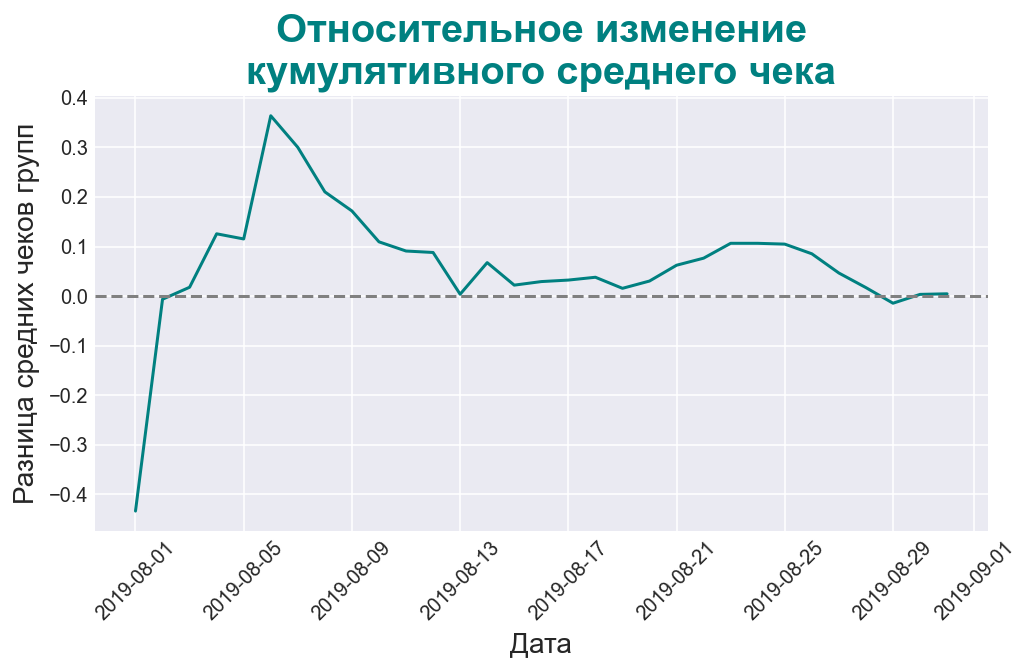

In [50]:
line(
    rel_data_clean,
    'rel_aov',
    'Относительное изменение\nкумулятивного среднего чека',
    'Разница средних чеков групп',
    hue=None)
plt.axhline(y=0, linestyle='--', color='gray');

Выводы те же: Группа В в основном опережает группу А, но периодически они равняются. Метрика не успела стабилизироваться.

## Вывод

1. Конверсия в покупку статистически значимо увеличилась на 16-17% по сырым и очищенным данным.  Это привело и к увеличению выручки.
2. Об изменении среднего чека говорить рано: метрика не стабилизировалась, графики продолжают колебаться.
3. При этом средний чек скорее всего не уменьшился: тест Манна-Уитни показывает, что группы почти не отличаются по этому оказателю, а графики говорят о том, что средний чек группы В или чуть выше, или такой же, как у группы А.
4. Так как основные ресурсы на проведение теста уже потрачены (продуман дизайн теста, разработаны и внедрены изменения, собраны данные), а дальнейшее проведение теста не угрожает уменьшением прибыли (выручка стабильно растёт, не видно предпосылок к резкому снижению среднего чека), **стоит продолжить тест** до тех пор, пока не стабилизируется показатель среднего чека и не появится статистически значимых различий. Если метрика увеличится, тест можно будет считать успешным. Если останется такой же или незначительно уменьшится, а выручка за счёт увеличившейся конверсии останется более высокой по сравнению с группой А, тест также можно будет считать успешным. Если же средний чек по результатам теста уменьшится настолько, что выручка снизится, тест нужно будет закончить и признать неуспешным.